# Requirements

## Libraries

In [2]:
# !pip install -r requirements.txt

In [3]:
import cv2
from roboflow import Roboflow
from bs4 import BeautifulSoup
import os
import shutil
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import random
from Cavity_detection.src.utils import *
from Cavity_detection.src.secrets import ROBOFLOW_API_KEY, ROBOFLOW_API_KEY_2, ROBOFLOW_API_KEY_3

## Directories and definitions

In [4]:
base_path= 'Cavity_detection'

In [5]:
data = os.path.join(base_path, 'data')
raw_data = os.path.join(data, 'raw')
external_data = os.path.join(data, 'external')
interim_data = os.path.join(data, 'interim')
interim_caries = os.path.join(interim_data, 'caries')
interim_no_caries = os.path.join(interim_data, 'no_caries')
interim_caries_rois = os.path.join(interim_caries, 'rois')
rejected_rois = os.path.join(interim_caries, 'rejected_rois')
processed_data = os.path.join(data, 'processed')
processed_caries = os.path.join(processed_data, 'caries')
processed_no_caries = os.path.join(processed_data, 'no_caries')

In [5]:
directories = [data, raw_data, external_data, interim_data, interim_caries,
               interim_no_caries, interim_caries_rois, rejected_rois, 
               processed_data, processed_caries, processed_no_caries]

In [6]:
empty_directory(interim_data)
empty_directory(processed_data)
empty_directory(external_data)
create_missing_folders(directories)

In [7]:
# clahe creation
clahe = cv2.createCLAHE(clipLimit =10.0, tileGridSize=(8,8)) # Parameters used in original paper

In [8]:
# height and width
height = 100
width = 100

# Raw

## Data download

In [9]:
# download dataset from roboflow to data/external and copy it to data/raw
def download_raw_data(download_dir, raw_data_dir, overwrite_external:bool=False):
  if overwrite_external:
    empty_directory(download_dir)
    empty_directory(raw_data_dir)
  rf = Roboflow(api_key=ROBOFLOW_API_KEY)
  # first image batch
  project = rf.workspace("lesiones-dentales-1").project("dental-lesions-oa6kb")
  dataset = project.version(5).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)
  
  # second image batch
  rf = Roboflow(api_key=ROBOFLOW_API_KEY_2)
  project = rf.workspace("lesiones-dentales-2").project("dental-lesions-2")
  dataset = project.version(4).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)

# third image batch
  rf = Roboflow(api_key=ROBOFLOW_API_KEY_3)
  project = rf.workspace("lesiones-dentales-3").project("dental-lessions3")
  dataset = project.version(1).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)


In [10]:
download_raw_data(external_data, raw_data, True)

loading Roboflow workspace...
loading Roboflow project...
Extracting Dataset Version Zip to Cavity_detection/data/external in voc:: 100%|██████████| 1734/1734 [00:04<00:00, 409.47it/s]
loading Roboflow workspace...
loading Roboflow project...
Extracting Dataset Version Zip to Cavity_detection/data/external in voc:: 100%|██████████| 2002/2002 [00:09<00:00, 219.88it/s]
loading Roboflow workspace...
loading Roboflow project...
Extracting Dataset Version Zip to Cavity_detection/data/external in voc:: 100%|██████████| 306/306 [00:01<00:00, 214.33it/s]


In [11]:
img_counter("Cavity_detection/data/external/train")

2018

In [12]:
img_counter(raw_data)

2018

# Interim
caries and no_caries separation
caries roi creation (without clahe)
exploratoy analisys

## cavity / no cavity separation

Based on the 'caries' nametag in xml files, separate in 2 directories images that have cavities and those that not

In [13]:
# Open each xml at raw_data and check for 'caries' in nametag to separate in folders
def split_classes(raw_data_path):
  raw_data= raw_data_path

  # empty caries - no_caries paths
  shutil.rmtree(interim_caries, ignore_errors=True)
  shutil.rmtree(interim_no_caries, ignore_errors=True)
  create_missing_folders(directories)

  xmls = [xml for xml in os.listdir(raw_data) if xml.endswith('.xml')]
  for xml in xmls:
    with open(file_path(raw_data, xml)) as f:
      opened_xml = f.read()
    parsed_xml = BeautifulSoup(opened_xml, "xml") # reading xml
    filename = parsed_xml.find('filename').text
    if parsed_xml.find('name', string='caries') is not None: #check for caries nametag
      # copy xml and related image to cavities path
      shutil.copyfile(file_path(raw_data, xml), file_path(interim_caries, xml)) 
      shutil.copyfile(file_path(raw_data, filename), file_path(interim_caries, filename))
    else:
      # copy xml and related image to no cavities path
      shutil.copyfile(file_path(raw_data, xml), file_path(interim_no_caries, xml))
      shutil.copyfile(file_path(raw_data, filename), file_path(interim_no_caries, filename))


In [14]:
split_classes(raw_data)

In [6]:
img_counter(interim_caries)

848

In [7]:
img_counter(interim_no_caries)

1170

## caries roi creation

In [16]:
def extend_bounding_box(bbox, target_height, target_width, image_height, image_width):
    # bbox coordinates
    xmin, ymin, xmax, ymax = bbox
    bbox_height = ymax - ymin
    bbox_width = xmax - xmin

    # if bbox is bigger, update target values according to the original ratio (expand the smaller h or w)
    if bbox_height > target_height or bbox_width > target_width:
        ratio = target_height / target_width
        if bbox_height > bbox_width:
            target_height = bbox_height
            target_width = bbox_height / ratio
        if bbox_width > bbox_height:
            target_width = bbox_width
            target_height = bbox_width * ratio

    # pixels to extend
    height_delta = target_height - bbox_height 
    width_delta = target_width - bbox_width

    # extend pixels while mantaining the bbox centered
    ymin = ymin - height_delta/2
    ymax = ymax + height_delta/2
    xmin = xmin - width_delta/2
    xmax = xmax + width_delta/2

    # extend to the other side if pixels were extender further than the original image borders
    if ymin < 0:
        ymax = ymax - ymin
        ymin = 0
    if ymax > image_width:
        height_delta = ymax - image_width
        ymax =  ymax - height_delta
        ymin = ymin - height_delta

    if xmin < 0:
        xmax = xmax - xmin
        xmin = 0
    if xmax > image_width:
        width_delta = xmax - image_width
        xmax = xmax - width_delta
        xmin = xmin - width_delta
    
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

In [17]:
# Create and save roi's, applying clahe by default (needs to be applied to the full image first)
def roi_creation(images_path, save_dir, extend_bbox=False, apply_clahe:bool=True, visual_compare:bool=False, empty_roi_dir:bool=True, height:int=None, width:int=None, percentage:float=None, rejected_dir:str=None):
  if empty_roi_dir:
    empty_directory(save_dir)
    empty_directory(rejected_dir)

  cavity_counter = 0
  for xml in os.listdir(images_path):
      if xml.endswith('.xml'): # Check only xml files
        with open(file_path(images_path, xml)) as f:
          opened_xml = f.read()
        parsed_xml = BeautifulSoup(opened_xml, "xml")
        filename = parsed_xml.find('filename').text
        cavities = [cavity.find_parent() for cavity in parsed_xml.find_all('name', string='caries')] # List of cavities per file
        for cavity in cavities:
          # save coordinates of each cavity
          x_min = int(cavity.find('bndbox').find('xmin').string)
          x_max = int(cavity.find('bndbox').find('xmax').string)
          y_min = int(cavity.find('bndbox').find('ymin').string)
          y_max = int(cavity.find('bndbox').find('ymax').string)

          # verify roi ratio to image
          roi_height = y_max - y_min
          roi_width = x_max - x_min
          roi_area = roi_height * roi_width
          roi_ratio = roi_area / (height*width)

          img_filename = f'{cavity_counter}_{roi_ratio}.jpg'
          if roi_ratio < percentage:
            # save roi to rejected folder
            img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_UNCHANGED) # read img as it is
            roi = img[ y_min:y_max,x_min:x_max] #axes are y:x
            cv2.imwrite(file_path(rejected_dir, img_filename),roi) # save roi to rejected_dir
          else:
            # processing and save roi to save_dir
            if extend_bbox:
              img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_GRAYSCALE) # read img as grayscale
              img_width, img_height = img.shape
              bbox = [x_min, y_min, x_max, y_max]
              x_min, y_min, x_max, y_max = extend_bounding_box(bbox, height, width, img_height, img_width)
            if apply_clahe:
              img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_GRAYSCALE) # read img as grayscale
              clahe_img = clahe.apply(img)
              roi = clahe_img[ y_min:y_max,x_min:x_max] #axes are y:x
            else:
              img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_UNCHANGED) # read img as it is
              roi = img[ y_min:y_max,x_min:x_max] #axes are y:x
          
            cv2.imwrite(file_path(save_dir, img_filename),roi) # save roi to save_dir

          if visual_compare:
            # bounding_box for visualization
            boxA = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=1, edgecolor='r', facecolor='none')
            # Image comparation
            fig, axes = plt.subplots(nrows=1, ncols=2)
            axes[0].imshow(img,cmap=plt.cm.gray)
            axes[0].add_patch(boxA)
            axes[1].imshow(roi,cmap=plt.cm.gray)
            fig.tight_layout()
            plt.rcParams['figure.figsize'] = [10, 10]
            plt.show()
            print(file_path(save_dir, str(cavity_counter) + '.jpg'), '\n')

          cavity_counter += 1


In [18]:
roi_creation(interim_caries,interim_caries_rois, extend_bbox=True, visual_compare=False, height=height, width=width, percentage=0.5, rejected_dir=rejected_rois)

In [19]:
caries_number = img_counter(interim_caries_rois)
caries_number

962

In [20]:
img_counter(rejected_rois)

143

## no_caries roi creation

In [21]:
def extract_random_regions(src_dir, dest_dir, num_regions, height, width, apply_clahe=True):
    empty_directory(processed_no_caries)
    create_missing_folders(directories)
    counter = 0
    filenames = [f for f in os.listdir(src_dir) if f.endswith(".jpg") or f.endswith(".png")]
    while counter < num_regions:
        filename = random.choice(filenames)
        img_path = os.path.join(src_dir, filename)

        # image reading and processing
        if apply_clahe:
          img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) # read img as grayscale
          clahe_img = clahe.apply(img)
        else:
          img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # read img as it is

        # extract region from apropiate
        if len(img.shape) == 2:
                h, w = img.shape
                c = 1
        else:
          h, w, c = img.shape

        # random coordinates of the region
        x1 = random.randint(0, w - width)
        y1 = random.randint(0, h - height)
        x2 = x1 + width
        y2 = y1 + height

        if c == 1:
          region = img[y1:y2, x1:x2]
        else:
          region = img[y1:y2, x1:x2, :]

        region_filename = f"{counter}.jpg"
        region_path = os.path.join(dest_dir, region_filename)
        cv2.imwrite(region_path, region)
        counter += 1


In [22]:
extract_random_regions(interim_no_caries,processed_no_caries,caries_number,height, width)

In [23]:
img_counter(processed_no_caries)

962

# Data exploratory analysis

## roi's sizes

In [24]:
def get_picture_dimensions(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            try:
                image = Image.open(os.path.join(directory, filename))
                images.append([filename, image.height, image.width])
            except IOError:
                print("Cannot open", filename)
    return pd.DataFrame(images, columns=['Filename', 'Height', 'Width'])


In [25]:
roi_sizes_df = get_picture_dimensions(interim_caries_rois)

In [26]:
roi_sizes_df.describe()

,Height,Width
count,962.000000,962.000000
mean,183.133056,182.442827
std,69.217907,68.733128
min,100.000000,89.000000
25%,130.000000,130.000000
50%,170.000000,169.000000
75%,219.000000,219.000000
max,487.000000,487.000000


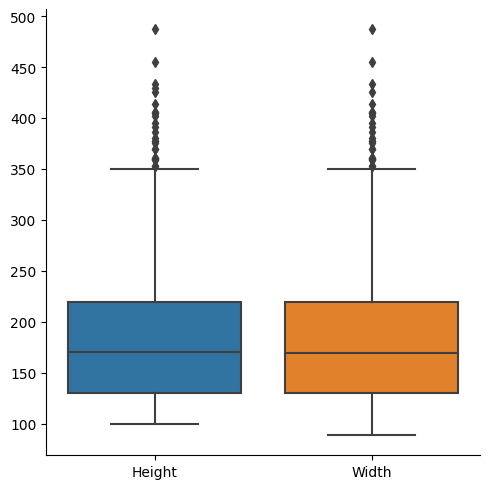

In [27]:
sns.catplot(data=roi_sizes_df, kind='box')
# sns.swarmplot(data=roi_sizes_df, color='black',alpha=0.5)

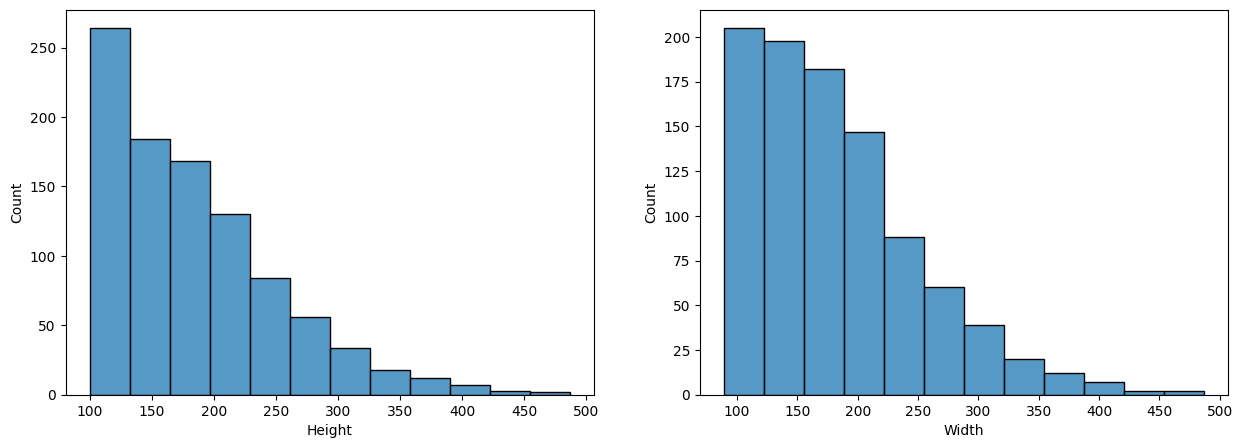

In [28]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(ax = axes[0], data=roi_sizes_df, x='Height', bins=12)
sns.histplot(ax = axes[1], data=roi_sizes_df, x='Width', bins=12)
plt.show()

# Processing

## Gauss noise padding

In [29]:
def gauss_padding(image, height, width):
    # Get image shape
    if len(image.shape) == 2:
        h, w = image.shape
        c = 1
    else:
        h, w, c = image.shape # (height, width, channels)

    # Calculate scaling factor
    scaling_factor = min(height / h, width / w)

    # Generate Gaussian noise with same mean and standard deviation as the original image
    noise = np.random.normal(np.mean(image), np.std(image), (height, width, c))

    # Resize image while keeping aspect ratio
    if scaling_factor < 1:
        image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        if len(image.shape) == 2:
            h, w = image.shape
            c = 1
        else:
            h, w, c = image.shape

    # center the image in the noise array
    if c == 1:
      noise = np.squeeze(noise)
      noise[(height - h)//2:(height - h)//2 + h, (width - w)//2:(width - w)//2 + w] = image
    else:
      noise[(height - h)//2:(height - h)//2 + h, (width - w)//2:(width - w)//2 + w, :] = image

    return noise


In [30]:
# apply gauss noise padding to all directory
def process_images(input_dir, output_dir, height, width, add_padding = False):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get list of files in input directory
    files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    for file in files:
        # Load image from file
        image = cv2.imread(os.path.join(input_dir, file), cv2.IMREAD_UNCHANGED)

        # Center and add noise to image
        if add_padding:
            result = gauss_padding(image, height, width)
        else:
            # also try INTER_LANCZOS4
            result = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA)

        # Save result to output directory
        cv2.imwrite(os.path.join(output_dir, file), result)


In [31]:
process_images(interim_caries_rois, processed_caries,height, width, add_padding=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f63fdc3-7b28-4cc7-8735-09f23d070fd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>